In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
def simulate_btc_price(S0, mu, sigma, T, N, M):
    dt = T / N
    Z = np.random.normal(0, 1, (M, N)) 
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    
    for t in range(1, N+1):
        S[:, t] = S[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    
    return S

In [4]:
def filter_paths(paths, threshold):
    final_prices = paths[:, -1]
    filtered_paths = paths[final_prices >= threshold]
    return filtered_paths

In [5]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [6]:
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

In [7]:
def calculate_option_payoff(S, K, T_expiration, N):
    n_expiration = int(T_expiration * N)
    payoff = np.maximum(S[:, n_expiration] - K, 0)
    return payoff

In [8]:
def calculate_put_payoff(S, K, T_expiration, N):
    n_expiration = int(T_expiration * N)
    payoff = np.maximum(K - S[:, n_expiration], 0)
    return payoff

In [9]:
def calculate_total_payoff_with_short_put(S, payoff_short, payoff_long, payoff_short_put, 
                                          initial_price_short_call, initial_price_long_call, 
                                          initial_price_short_put, btc_holding_value, S0, btc_long_amount, N, T_long):
    
    realized_profit_short_call = np.where(payoff_short > 0, payoff_short, 0)
    realized_profit_long_call = np.where(payoff_long > 0, payoff_long, 0)
    realized_profit_short_put = initial_price_short_put - np.where(payoff_short_put > 0, payoff_short_put, 0)

    net_payoff_options = realized_profit_long_call - realized_profit_short_call + realized_profit_short_put - (initial_price_long_call - initial_price_short_call)
    
    final_btc_value = btc_long_amount * S[:, int(T_long * N)]
    
    total_payoff = net_payoff_options + final_btc_value - (btc_long_amount * S0)
    # print("Realized Profit Short Call:", realized_profit_short_call)
    # print("Realized Profit Long Call:", realized_profit_long_call)
    # print("Realized Profit Short Put:", realized_profit_short_put)
    # print("Final BTC Value:", final_btc_value)
    # print("Net Payoff Options:", net_payoff_options)
    
    return total_payoff

In [10]:
def plot_btc_price_paths(S):
    plt.figure(figsize=(10, 6))
    for i in range(S.shape[0]):
        plt.plot(S[i, :], color='gray', alpha=0.1)
    plt.title("Simulated BTC Price Paths")
    plt.xlabel("Time Steps")
    plt.ylabel("BTC Price")
    plt.show()

In [11]:
def plot_payoff_distribution(total_payoff):
    plt.figure(figsize=(10, 6))
    plt.hist(total_payoff, bins=50, alpha=0.7, color='green')
    plt.title("Distribution of Total Payoffs from Bullish Calendar Spread + BTC Holdings")
    plt.xlabel("Net Payoff")
    plt.ylabel("Frequency")
    plt.show()

In [12]:
def calculate_option_prices_along_path(S, K, T_expiration, r, sigma, N, option_type='call'):
    option_prices = np.zeros(S.shape)
    dt = T_expiration / N
    
    for t in range(1, N+1):
        T = T_expiration - t * dt
        if option_type == 'call':
            option_prices[:, t] = black_scholes_call(S[:, t], K, T, r, sigma)
        elif option_type == 'put':
            option_prices[:, t] = black_scholes_put(S[:, t], K, T, r, sigma)
    
    return option_prices

In [13]:
# Parameters
S0 = 59000  # Initial BTC price
mu = 0.05  # Drift
sigma = 0.5  # Annualized volatility
T = 0.22  # Time horizon in years
N = 252  # Number of time steps (e.g., daily steps)
M = 10000  # Number of simulations
r = 0.01  # Risk-free rate

# Calendar spread parameters
K_short = 64000  # Strike price of the short call option
K_long = 64000  # Strike price of the long call option
T_short = 0.106  # Time to expiration of the short call 
T_long = 0.18  # Time to expiration of the long call 
initial_price_short_call = 2284  # Initial price of the short call option
initial_price_long_call = 3715  # Initial price of the long call option

# Put option parameters 
K_put = 56000  # Strike price of the short put option
T_put = 0.18  # Time to expiration of the short put option 
initial_price_short_put = 3759  # Initial price of the short put option


In [14]:
# BTC long position
btc_holding_value = 1 * S0  # Value of initial BTC holdings
btc_long_amount = 1  # Amount of BTC held throughout the simulation

In [15]:
S = simulate_btc_price(S0, mu, sigma, T, N, M)
S = filter_paths(S, 50000)

payoff_short_call = calculate_option_payoff(S, K_short, T_short, N)
payoff_long_call = calculate_option_payoff(S, K_long, T_long, N)
payoff_short_put = calculate_put_payoff(S, K_put, T_put, N)



# Calculate the value of BTC holdings at the long-term expiration
btc_holding_value = btc_long_amount * S[:, int(T_long * N)]

total_payoff = calculate_total_payoff_with_short_put(S, payoff_short_call, payoff_long_call, payoff_short_put, 
                                                     initial_price_short_call, initial_price_long_call, 
                                                     initial_price_short_put, btc_holding_value, S0, btc_long_amount, N, T_long)
# Calculate option prices along the path
option_prices_short = calculate_option_prices_along_path(S, K_short, T_short, r, sigma, N)
option_prices_long = calculate_option_prices_along_path(S, K_long, T_long, r, sigma, N)

# Calculate the expected payoff and probability of profit
expected_payoff = np.mean(total_payoff)
prob_profit = np.mean(total_payoff > 0)

C:\Users\Kiran\AppData\Local\Temp\ipykernel_20136\230175886.py:2: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Expected Net Payoff Including BTC Holdings: 3318.67
Probability of Profit: 71.66%


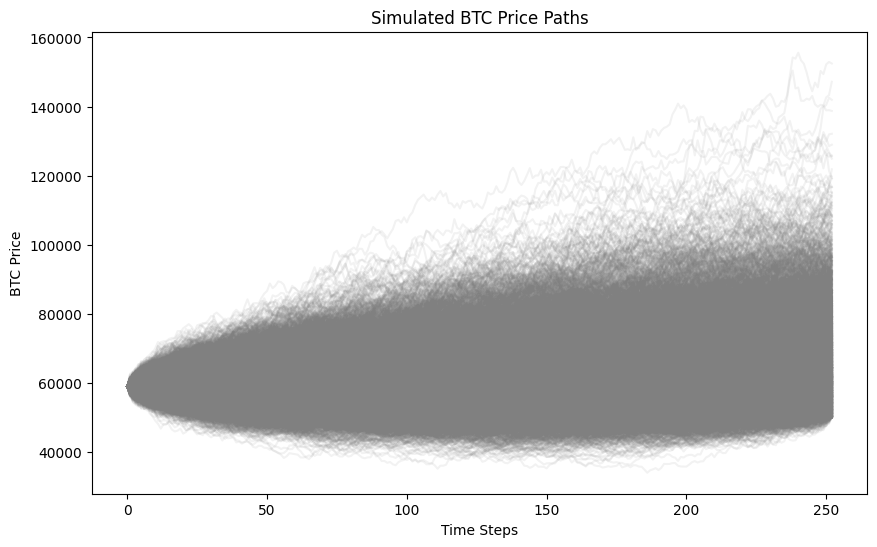

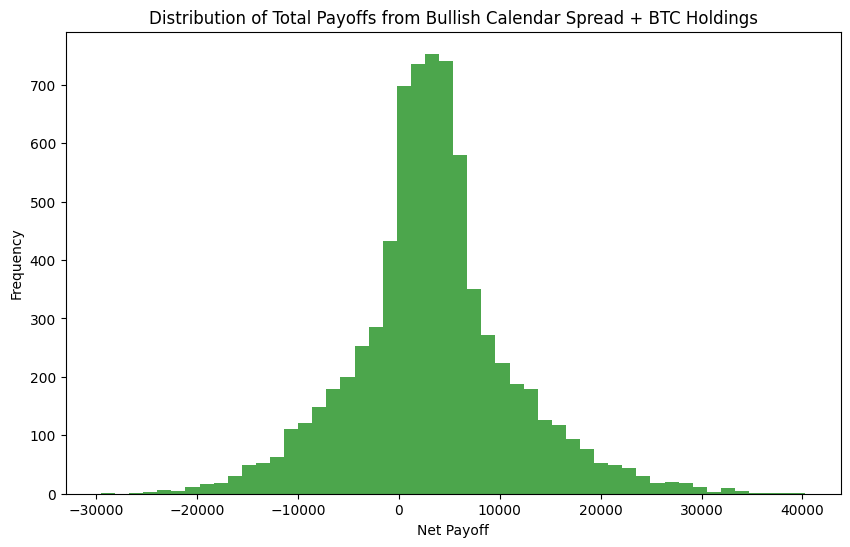

Predicted Option Prices at Expiration:
Short Call Option Prices: [    0.          8568.56510424 17399.42013643 ...     0.
 15454.79168534     0.        ]
Long Call Option Prices: [    0.          8568.56510424 17399.42013643 ...     0.
 15454.79168534     0.        ]


In [16]:
print(f"Expected Net Payoff Including BTC Holdings: {expected_payoff:.2f}")
print(f"Probability of Profit: {prob_profit * 100:.2f}%")

plot_btc_price_paths(S)

plot_payoff_distribution(total_payoff)

print("Predicted Option Prices at Expiration:")
print("Short Call Option Prices:", option_prices_short[:, -1])
print("Long Call Option Prices:", option_prices_long[:, -1])